In [41]:
# Load Libraries
import os, re
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (9,6)
plt.rcParams['axes.grid'] = True

os.makedirs("Images", exist_ok=True)
os.makedirs("Outputs", exist_ok=True)

In [13]:
# Load Data
df=pd.read_csv('C:/Users/Ismail/Desktop/default Data/store/GroceryDataset.csv')
print(df.shape)
df.head()

(1757, 8)


,Sub Category,Price,Discount,Rating,Title,Currency,Feature,Product Description
0,Bakery & Desserts,$56.99,No Discount,Rated 4.3 out of 5 stars based on 265 reviews.,"David’s Cookies Mile High Peanut Butter Cake, ...",$,"""10"""" Peanut Butter Cake\nCertified Kosher OU-...",A cake the dessert epicure will die for!Our To...
1,Bakery & Desserts,$159.99,No Discount,Rated 5 out of 5 stars based on 1 reviews.,"The Cake Bake Shop 8"" Round Carrot Cake (16-22...",$,Spiced Carrot Cake with Cream Cheese Frosting ...,"Due to the perishable nature of this item, ord..."
2,Bakery & Desserts,$44.99,No Discount,Rated 4.1 out of 5 stars based on 441 reviews.,"St Michel Madeleine, Classic French Sponge Cak...",$,100 count\nIndividually wrapped\nMade in and I...,Moist and buttery sponge cakes with the tradit...
3,Bakery & Desserts,$39.99,No Discount,Rated 4.7 out of 5 stars based on 9459 reviews.,"David's Cookies Butter Pecan Meltaways 32 oz, ...",$,Butter Pecan Meltaways\n32 oz 2-Pack\nNo Prese...,These delectable butter pecan meltaways are th...
4,Bakery & Desserts,$59.99,No Discount,Rated 4.5 out of 5 stars based on 758 reviews.,"David’s Cookies Premier Chocolate Cake, 7.2 lb...",$,"""10"" Four Layer Chocolate Cake\nCertified Kosh...",A cake the dessert epicure will die for!To the...


In [14]:
# show missing value 
na_before=df.isna().sum().sort_values(ascending=False)
print('Missing Before:\n',na_before)

Missing Before:
 Rating                 1075
Product Description      42
Feature                  18
Currency                  5
Price                     3
Sub Category              0
Discount                  0
Title                     0
dtype: int64


In [34]:
# remove'$' and convert to numeric
df['Price']=pd.to_numeric(df['Price'],errors='coerce')

In [35]:
# impute missing prices by sub category median 
price_med_by_cat = df.groupby('Sub Category')['Price'].transform('median')
df['Price'] = df['Price'].fillna(price_med_by_cat).fillna(df['Price'].median())

In [36]:
# Normalize discount to numeric 
df['Discount']=df['Discount'].replace({'No Discount':0})
df['Discount']=(df['Discount'].astype(str)
                .str.replace('$','',regex=False)
                .str.strip())
df['Discount']=pd.to_numeric(df['Discount'],errors='coerce').fillna(0.0)
df['HasDiscount']=(df['Discount']>0).astype(int)

In [37]:
# Extract numeric rating
df['Rating_num']=(df['Rating']
                  .astype(str)
                  .str.extract(r'(\d+\.\d+|\d+)')
                  .astype(float))

In [42]:
# Extract review count from pharses 
df['Reviews']=(df['Rating']
               .astype(str)
               .str.extract(r'based on\s+(\d[\d,]*)\s+reviews',flags=re.I)[0]
               .str.replace(',','',regex=False)
               .astype(float))

In [43]:
# Imput missing rating by Sub Category mean
df['Rating_num']=(df['Rating_num']
                  .fillna(df.groupby('Sub Category')['Rating_num'].transform('median'))
                  .fillna(df['Rating_num'].mean()))

In [44]:
# Missing reviews become 0 
df['Reviews']=df['Reviews'].fillna(0).astype(int)

In [45]:
# compute final price after discount
df['FinalPrice']=df['Price']*(1-df['Discount']/100.0)

In [46]:
# Helper to extract first number before a unit token
def extract_first_num(text,pattern):
    s=str(text)
    m=re.search(pattern,s,flags=re.I)
    if m:
        return float(m.group(1).replace(',',''))
        return np.nan

In [48]:
# Try multiple text sources for oz and count
for col in ['Title','Feature','Product Description']:
    df[f'oz_from_{col}']=df[col].apply(lambda x:extract_first_num(x,r'(\d+(\.\d+)?)\s*oz'))
    df[f'ct_from_{col}'] = df[col].apply(lambda x: extract_first_num(x, r'(\d+)\s*(?:count|ct|pack)'))

In [49]:
# combine best guess for size and count 
df['Size_oz']=df[[c for c in df.columns if c.startswith('oz_from_')]].bfill(axis=1).iloc[:,0]
df['PackCount']=df[[c for c in df.columns if c.startswith('ct_from_')]].bfill(axis=1).iloc[:,0]

In [50]:
df[['FinalPrice','Size_oz','PackCount']]

,FinalPrice,Size_oz,PackCount
0,56.99,NaN,NaN
1,159.99,NaN,NaN
2,44.99,NaN,100.0
3,39.99,32.0,NaN
4,59.99,NaN,NaN
...,...,...,...
1752,23.99,3.0,NaN
1753,49.99,2.1,NaN
1754,22.99,48.0,30.0
1755,17.49,NaN,NaN


In [53]:
print('Missing PackCount :',df['PackCount'].isna().sum())
print('Missing Size_oz :',df['Size_oz'].isna().sum())

Missing PackCount : 1474
Missing Size_oz : 832


In [56]:
# Length-based features from text fields 
df['Title_len']=df['Title'].astype(str).str.len()
df['Feat_len']=df['Feature'].astype(str).str.len()
df['Desc_len']=df['Product Description'].astype(str).str.len()

In [57]:
# Simple product tags from keywords
keywords = {
    'is_chocolate':r'chocolate|coca',
    'is_vanilla':r'vanilla',
    'is_peanut':r'peanut|nut',
    'is_vegan':r'\bvegan\b',
    'is_organic':r'\borganic\b',
    'is_kosher':r'\bkosher\b',
    'is_gultenfree':r'gluten[-\s]?free'
}
text_all=(df['Title'].astype(str)+' '+df['Feature'].astype(str)+' '+df['Product Description'].astype(str)).str.lower()

for newcol, pat in keywords.items():
    df[newcol]=text_all.str.contains(pat, regex=True).astype(int)

In [58]:
# Higher rating and Lower price => higher score
r=(df['Rating_num']-df['Rating_num'].min())/(df['Rating_num'].max()-df['Rating_num'].min()+ 1e-9)
p=(df['FinalPrice']-df['FinalPrice'].min())/(df['FinalPrice'].max()-df['FinalPrice'].min()+ 1e-9)

In [59]:
df['ValueScore']=(0.7*r+0.3*(1-p)) # weight rating more than price

In [62]:
# Bayesian weighted rating (IMDb-style) using Reviews as confidence
C = df['Rating_num'].mean()
m = np.percentile(df['Reviews'],75) # Only count items with many reviews
v=df['Reviews']
R=df['Rating_num']
df['BayesRating']=(v/(v+m))*R + (m/(v+m))*C

In [63]:
# Flag extremely high/low prices using IQR 
Q1,Q3=df['FinalPrice'].quantile([0.25,0.75])
IQR=Q3-Q1
low, high=Q1-1.5*IQR,Q3+1.5*IQR
df['IsPriceOutlier']=((df['FinalPrice']<low) | (df['FinalPrice']>high)).astype(int)

In [67]:
# Category summary with strong KPIs
cat_summary=(df
             .groupby('Sub Category')
             .agg(n_items=('Title','count'),
                      avg_price=('FinalPrice','mean'),
                      avg_rating=('Rating_num','mean'),
                      avg_bayes=('BayesRating','mean'),
                      discount_share=('HasDiscount','mean'))
             .sort_values(['avg_bayes','avg_price'],ascending=[False,True]))
cat_summary.round(2).head(10)
                    

,n_items,avg_price,avg_rating,avg_bayes,discount_share
Sub Category,,,,,
Laundry Detergent & Supplies,39,33.90,4.57,4.49,0.0
Organic,33,22.42,4.64,4.49,0.0
Coffee,95,32.88,4.57,4.48,0.0
Breakfast,21,13.30,4.75,4.47,0.0
Kirkland Signature Grocery,122,28.12,4.60,4.47,0.0
Pantry & Dry Goods,171,29.10,4.58,4.47,0.0
Cleaning Supplies,94,30.25,4.53,4.47,0.0
Poultry,9,159.43,4.48,4.46,0.0
Gift Baskets,89,118.74,4.46,4.46,0.0


In [69]:
# Top 5 value products within each Sub Category 
top_value=(df
           .sort_values(['Sub Category','ValueScore','BayesRating'],ascending=[True,False,False])
           .groupby('Sub Category')
           .head(5)
           [['Sub Category','Title','FinalPrice','Rating_num','Reviews','ValueScore','BayesRating']]
          )
top_value.head(10)

,Sub Category,Title,FinalPrice,Rating_num,Reviews,ValueScore,BayesRating
9,Bakery & Desserts,"The Cake Bake Shop 8"" Round Chocolate Cake (16...",159.99,5.0,2,0.976553,4.467487
1,Bakery & Desserts,"The Cake Bake Shop 8"" Round Carrot Cake (16-22...",159.99,5.0,1,0.976553,4.457626
22,Bakery & Desserts,deMilan Panettone Classico Tin Cake 2.2 lb Tin,24.99,4.7,687,0.944344,4.681908
3,Bakery & Desserts,"David's Cookies Butter Pecan Meltaways 32 oz, ...",39.99,4.7,9459,0.942089,4.698592
12,Bakery & Desserts,David's Cookies 90-piece Gourmet Chocolate Chu...,54.99,4.7,273,0.939835,4.658932
56,Beverages & Water,"Joyburst Energy Variety, 12 fl oz, 18-count",32.99,5.0,1,0.995641,4.457626
118,Beverages & Water,Pulp & Press Organic Cold-Pressed Juice Variet...,99.99,5.0,6,0.985571,4.503590
123,Beverages & Water,Tiesta Tea Loose Leaf Tea Variety 3-Pack (16 o...,69.99,4.9,62,0.972580,4.691407
155,Beverages & Water,Cherry Bay Orchards Tart Cherry Concentrate 32...,39.99,4.8,1251,0.959589,4.785669
70,Beverages & Water,Sencha Naturals Everyday Matcha Green Tea Powd...,49.99,4.8,1150,0.958086,4.784465


In [70]:
# compare items with and without discount 
disc_vs_rating=(df
                .groupby('HasDiscount')
                .agg(avg_price=('FinalPrice','mean'),
                     avg_rating=('Rating_num','mean'),
                     bayes=('BayesRating','mean'),
                     share=('Title','count'))
                .rename(index={0:'No discount',1:'Discount'}))
disc_vs_rating.round(2)
                     

,avg_price,avg_rating,bayes,share
HasDiscount,,,,
No discount,60.74,4.45,4.44,1757


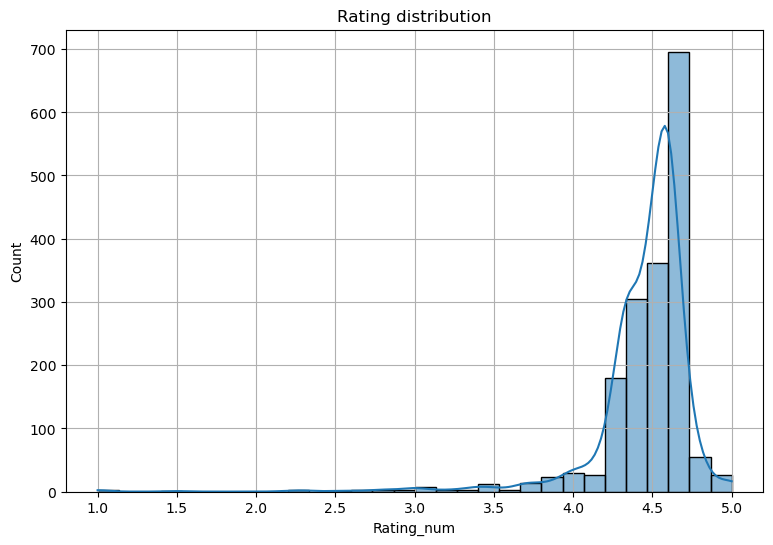

In [71]:
# Rating distribution
ax = sns.histplot(df['Rating_num'], bins=30, kde=True)
ax.set_title("Rating distribution")
plt.savefig("Images/fig_rating_dist.png", bbox_inches='tight'); plt.show()

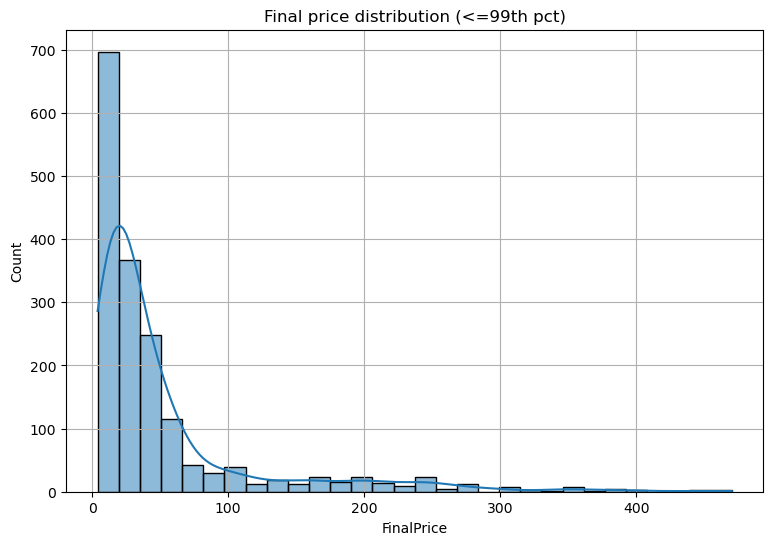

In [72]:
# Simple comment: Final price distribution (winsorized for nicer view)
cap = df['FinalPrice'].quantile(0.99)
ax = sns.histplot(df.loc[df['FinalPrice']<=cap, 'FinalPrice'], bins=30, kde=True)
ax.set_title("Final price distribution (<=99th pct)")
plt.savefig("Images/fig_price_dist.png", bbox_inches='tight'); plt.show()

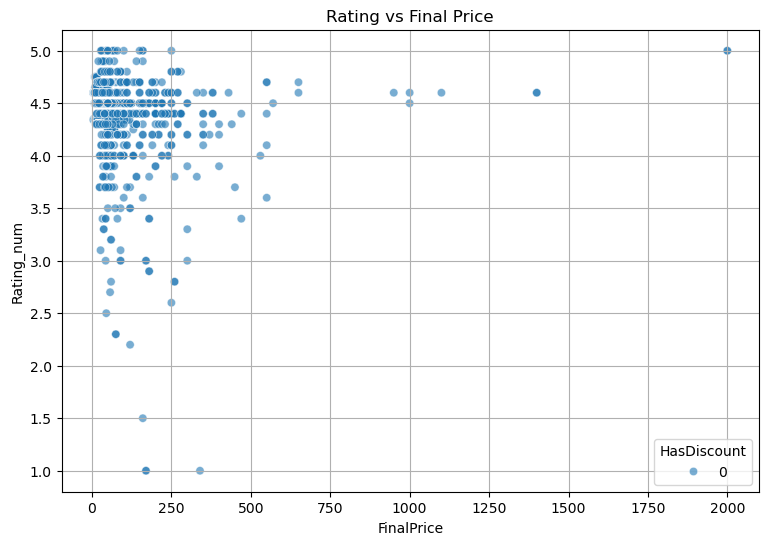

In [73]:
# Simple comment: Rating vs Final Price (colored by discount)
ax = sns.scatterplot(data=df, x='FinalPrice', y='Rating_num', hue='HasDiscount', alpha=0.6)
ax.set_title("Rating vs Final Price")
plt.savefig("Images/fig_rating_vs_price.png", bbox_inches='tight'); plt.show()

C:\Users\Ismail\AppData\Local\Temp\ipykernel_9304\1577075533.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(data=df[df['Sub Category'].isin(top_cats)],


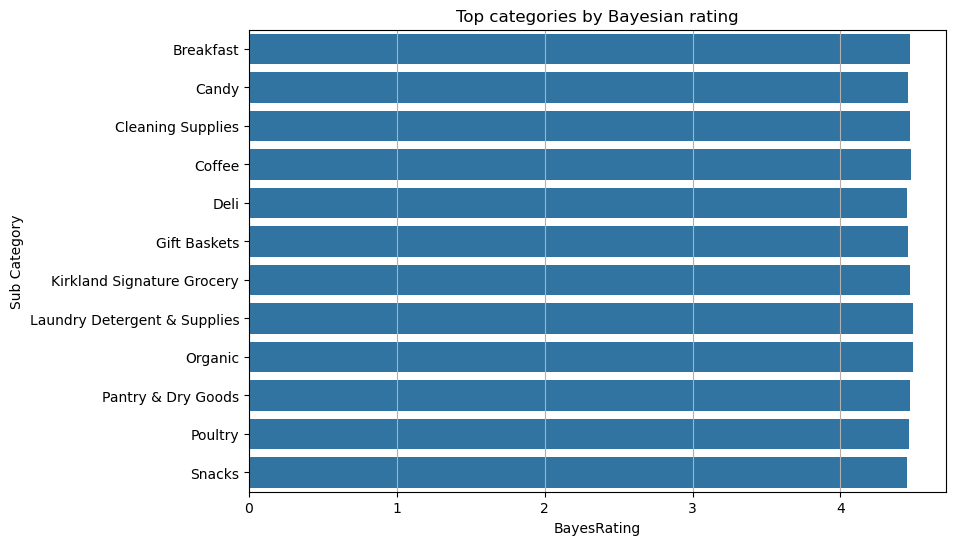

In [74]:
# Average Bayes rating by Sub Category (top 12)
top_cats = (cat_summary.sort_values('avg_bayes', ascending=False).head(12).index)
ax = sns.barplot(data=df[df['Sub Category'].isin(top_cats)],
                 x='BayesRating', y='Sub Category', estimator=np.mean, ci=None)
ax.set_title("Top categories by Bayesian rating")
plt.savefig("Images/fig_categories_bayes.png", bbox_inches='tight'); plt.show()

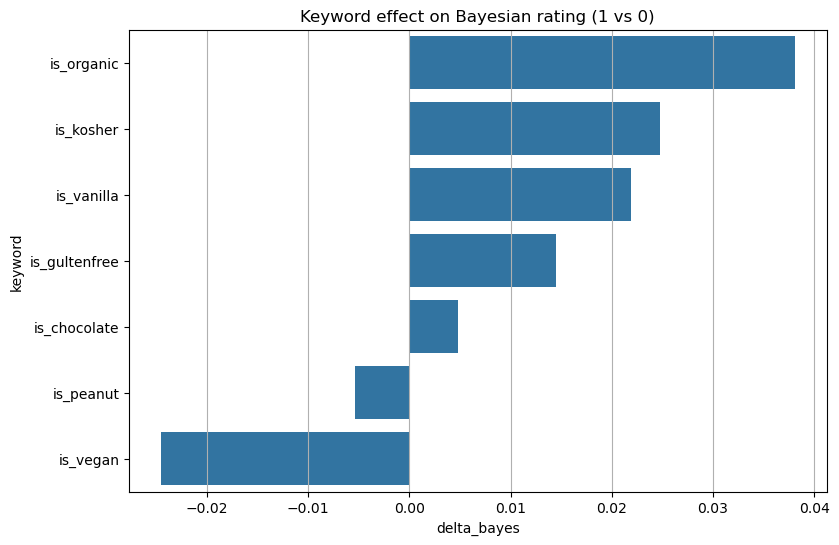

,keyword,delta_bayes
4,is_organic,0.038086
5,is_kosher,0.024783
1,is_vanilla,0.021868
6,is_gultenfree,0.014507
0,is_chocolate,0.004809
2,is_peanut,-0.005426
3,is_vegan,-0.024582


In [75]:
# Compare Bayesian rating for keyword tags
kw_cols = [c for c in df.columns if c.startswith('is_')]
kw_stats = []
for c in kw_cols:
    s = df.groupby(c)['BayesRating'].mean()
    kw_stats.append((c, float(s.get(1, np.nan)) - float(s.get(0, np.nan))))
kw_df = pd.DataFrame(kw_stats, columns=['keyword','delta_bayes']).sort_values('delta_bayes', ascending=False)

ax = sns.barplot(data=kw_df, x='delta_bayes', y='keyword')
ax.set_title("Keyword effect on Bayesian rating (1 vs 0)")
plt.savefig("Images/fig_keyword_bayes.png", bbox_inches='tight'); plt.show()

kw_df


In [77]:
# Save cleaned dataset and key tables
df.to_csv("Outputs/clean_grocery.csv", index=False)
cat_summary.round(3).to_csv("Outputs/category_summary.csv")
top_value.to_csv("Outputs/top_value_products.csv", index=False)
kw_df.to_csv("Outputs/keyword_effects.csv", index=False)
disc_vs_rating.round(3).to_csv("Outputs/discount_vs_rating.csv")

In [80]:
# Build a compact insight summary
insights = {}

# Top 5 categories by Bayesian rating
insights['top_categories_by_bayes'] = (cat_summary['avg_bayes']
                                       .sort_values(ascending=False).head(5))

# Best value products overall
insights['top_value_products'] = (df.sort_values(['ValueScore','BayesRating'], ascending=False)
                                  .head(5)[['Title','Sub Category','FinalPrice','Rating_num','Reviews','ValueScore','BayesRating']])

# Discount share by category (top)
insights['categories_with_most_discount'] = (cat_summary['discount_share']
                                             .sort_values(ascending=False).head(5))

# Keyword with strongest positive delta on Bayesian rating
insights['best_keywords'] = kw_df.head(5)

for k,v in insights.items():
    print(f"\n=== {k} ===\n", v)


=== top_categories_by_bayes ===
 Sub Category
Laundry Detergent & Supplies    4.492180
Organic                         4.488615
Coffee                          4.480105
Breakfast                       4.472386
Kirkland Signature Grocery      4.471721
Name: avg_bayes, dtype: float64

=== top_value_products ===
                                                   Title  \
1216  Namaste Gluten Free Waffle & Pancake Mix 3 lb ...   
1347  Artstyle Paper Plate & Napkin Bundle, Year of ...   
56          Joyburst Energy Variety, 12 fl oz, 18-count   
680                   eat.art Salt and Spice Set 2-pack   
1210                  eat.art Salt and Spice Set 2-pack   

                  Sub Category  FinalPrice  Rating_num  Reviews  ValueScore  \
1216        Pantry & Dry Goods       27.99         5.0        1    0.996393   
1347  Paper & Plastic Products       28.99         5.0        3    0.996242   
56           Beverages & Water       32.99         5.0        1    0.995641   
680             